## About WIS
Good ressources:
-  Supplement of Cramer et al.
- code cramer et al. here https://github.com/reichlab/covid19-forecast-evals
- obviously https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008618#sec015
- [git clone https://github.com/adrian-lison/interval-scoring.git](https://github.com/adrian-lison/interval-scoring/tree/master) Adrian Lison's code for WIS
- https://epiforecasts.io/scoringutils/ Scoring utils package -- perhaps best to use ?

In [1]:
from interval_scoring import scoring
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
# A modification of Lison's code that splits the calibration in underprediction and overprediction
def weighted_interval_score_fast(
    observations, alphas, q_dict, weights=None, percent=False, check_consistency=True
):
    """
    Compute weighted interval scores for an array of observations and a number of different predicted intervals.
    
    This function implements the WIS-score (2). A dictionary with the respective (alpha/2)
    and (1-(alpha/2)) quantiles for all alpha levels given in `alphas` needs to be specified.
    
    This is a more efficient implementation using array operations instead of repeated calls of `interval_score`.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    alphas : iterable
        Alpha levels for (1-alpha) intervals.
    q_dict : dict
        Dictionary with predicted quantiles for all instances in `observations`.
    weights : iterable, optional
        Corresponding weights for each interval. If `None`, `weights` is set to `alphas`, yielding the WIS^alpha-score.
    percent: bool, optional
        If `True`, score is scaled by absolute value of observations to yield a percentage error. Default is `False`.
    check_consistency: bool, optional
        If `True`, quantiles in `q_dict` are checked for consistency. Default is `True`.
        
    Returns
    -------
    total : array_like
        Total weighted interval scores.
    sharpness : array_like
        Sharpness component of weighted interval scores.
    calibration : array_like
        Calibration component of weighted interval scores.
        
    (2) Bracher, J., Ray, E. L., Gneiting, T., & Reich, N. G. (2020). Evaluating epidemic forecasts in an interval format. arXiv preprint arXiv:2005.12881.
    """
    if weights is None:
        weights = np.array(alphas)/2

    if not all(alphas[i] <= alphas[i + 1] for i in range(len(alphas) - 1)):
        raise ValueError("Alpha values must be sorted in ascending order.")

    reversed_weights = list(reversed(weights))

    lower_quantiles = [q_dict.get(alpha / 2) for alpha in alphas]
    upper_quantiles = [q_dict.get(1 - (alpha / 2)) for alpha in reversed(alphas)]
    if any(q is None for q in lower_quantiles) or any(
        q is None for q in upper_quantiles
    ):
        raise ValueError(
            f"Quantile dictionary does not include all necessary quantiles."
        )

    lower_quantiles = np.vstack(lower_quantiles)
    upper_quantiles = np.vstack(upper_quantiles)

    # Check for consistency
    if check_consistency and np.any(
        np.diff(np.vstack((lower_quantiles, upper_quantiles)), axis=0) < 0
    ):
        raise ValueError("Quantiles are not consistent.")

    lower_q_alphas = (2 / np.array(alphas)).reshape((-1, 1))
    upper_q_alphas = (2 / np.array(list(reversed(alphas)))).reshape((-1, 1))

    # compute score components for all intervals
    sharpnesses = np.flip(upper_quantiles, axis=0) - lower_quantiles

    lower_calibrations = (
        np.clip(lower_quantiles - observations, a_min=0, a_max=None) * lower_q_alphas
    )
    upper_calibrations = (
        np.clip(observations - upper_quantiles, a_min=0, a_max=None) * upper_q_alphas
    )
    calibrations = lower_calibrations + np.flip(upper_calibrations, axis=0)
    upper_calibrations = np.flip(upper_calibrations, axis=0)
    lower_calibrations = lower_calibrations

    # scale to percentage absolute error
    if percent:
        sharpnesses = sharpnesses / np.abs(observations)
        calibrations = calibrations / np.abs(observations)
        raise ValueError("Not Supported with the calibration split")

    totals = sharpnesses + calibrations

    # weigh scores
    weights = np.array(weights).reshape((-1, 1))

    sharpnesses_weighted = sharpnesses * weights
    calibrations_weighted = calibrations * weights
    upper_calibrations_weighted = upper_calibrations * weights
    lower_calibrations_weighted = lower_calibrations * weights
    totals_weighted = totals * weights

    # normalize and aggregate all interval scores
    weights_sum = np.sum(weights)

    sharpnesses_final = np.sum(sharpnesses_weighted, axis=0) / weights_sum
    calibrations_final = np.sum(calibrations_weighted, axis=0) / weights_sum
    upper_calibrations_final = np.sum(upper_calibrations_weighted, axis=0) / weights_sum
    lower_calibrations_final = np.sum(lower_calibrations_weighted, axis=0) / weights_sum
    totals_final = np.sum(totals_weighted, axis=0) / weights_sum

    return totals_final, sharpnesses_final, calibrations_final, lower_calibrations_final, upper_calibrations_final

In [3]:
image_size = 64
channels = 1
batch_size=512
season_first_year="2022"
import nn_blocks, idplots, ddpm, myutils, inpaint, ground_truth
gt1 = ground_truth.GroundTruth(season_first_year=season_first_year, 
                                data_date=datetime.datetime(2022,10,25), 
                                mask_date=datetime.datetime(2022,10,25),
                                channels=channels,
                                image_size=image_size,
                                nogit=True #so git is not damaged.
                            )

/nas/longleaf/home/chadi/.conda/envs/diffusion_torch6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Spatial Setup with 51 locations.
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Masking, >> 13 weeks already in data, inpainting the next ones


In [4]:
def score_Nwk_forecasts(gt, forecasts, n=4) -> pd.DataFrame: 
    if isinstance(gt, str):
        gt = pd.read_csv(gt)
    if isinstance(forecasts, str):
        forecast = pd.read_csv(forecast)

    # take only the locations and dates that are forecasted
    gt = gt[gt["location"].isin(forecasts["location"])]
    gt = gt[gt["date"].isin(forecasts.target_end_date)]

    #first_forecast_date = datetime.datetime.strptime(forecasts["target_end_date"].sort_values()[0], "%Y-%m-%d").date()
    #target_dates = pd.date_range(first_forecast_date, first_forecast_date + datetime.timedelta(days=n*7), freq="W-SAT").date

    gt_piv = gt.pivot(index="date", columns="location", values="value").sort_index()


    target_dict = dict(zip(gt_piv.index, [f"{n} wk ahead" for n in range(1,n+1)]))
    
    # Alpha for WIS
    alphas=np.array(sorted(forecasts["quantile"].unique()))[:11]*2
    
    # gt_piv.index should be similar to target_dict.keys() apart from format

    all_targets = []
    
    for target in target_dict.keys():
        f = forecasts[forecasts["target_end_date"] == target]
        q_dict = {}
        for q in f["quantile"].unique():
            q_dict[float(q)] = f[f["quantile"]==q].pivot(index=["target_end_date"], columns="location", values="value").sort_index().to_numpy().ravel()
        wis_total, wis_sharpness, wis_calibration, underprediction, overprediction =   weighted_interval_score_fast(observations=gt_piv.loc[target].to_numpy(), 
                                                                                        alphas=alphas, 
                                                                                        q_dict=q_dict, 
                                                                                        weights=alphas/2)
        df = pd.DataFrame([wis_total, wis_sharpness, wis_calibration, underprediction, overprediction], index = ["wis_total", "wis_sharpness", "wis_calibration", "wis_underprediction", "wis_overprediction"], columns=gt_piv.columns)
        df["target"] = target_dict[target]
        df["target_end_date"] = target    
        all_targets.append(df)

    
    return pd.concat(all_targets).reset_index(names="wis_type").set_index(["target", "target_end_date"])

In [5]:

# "CADPH-FluCAT_Ensemble",
flusight_model_list = [ # %ls Flusight/Flusight-forecast-data/data-forecasts
 "LUcompUncertLab-humanjudgment",
"CEID-Walk", "LUcompUncertLab-stacked_ili",
"CEPH-Rtrend_fluH", #"LosAlamos_NAU-CModel_Flu",
"CMU-TimeSeries", #"METADATA.m",
"CU-ensemble", "MIGHTE-Nsemble",
"Flusight-baseline", "MOBS-GLEAM_FLUH",
"Flusight-ensemble", "NIH-Flu_ARIMA",
"GH-Flusight", "PSI-DICE",
"GT-FluFNP", #"README.m",
"IEM_Health-FluProject", "SGroup-RandomForest",
"ISU_NiemiLab-Flu", "SGroup-SIkJalpha",
"JHUAPL-Gecko", #"SigSci-CREG",
"JHU_IDD-CovidSP", #"SigSci-TSENS",
"LUcompUncertLab-HWAR2", "UGA_flucast-OKeeffe",
"LUcompUncertLab-KalmanFilter", "UGuelph-FluPLUG",
"LUcompUncertLab-TEVA", "UMass-gbq",
"LUcompUncertLab-VAR2", "UMass-trends_ensemble",
"LUcompUncertLab-VAR2K", "UNC_IDD-InfluPaint",
"LUcompUncertLab-VAR2K_plusCOVID", "UT_FluCast-Voltaire",
"LUcompUncertLab-VAR2_plusCOVID", "UVAFluX-Ensemble",
"LUcompUncertLab-ensemble_rclp", "Umass-ARIMA",
#"LUcompUncertLab-experthuman", "VTSanghani-ExogModel",
"LUcompUncertLab-hier_mech_model", "VTSanghani-Transformer"]

model_list = ["UNC_IDD-InfluPaint"]
model_list = flusight_model_list

In [27]:
my_model_list = ["test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_30",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_Repaint::resamp_30",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScale::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScale::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScale::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScale::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScale::800::inpaint_Repaint::resamp_30",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_30",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_No::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_No::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_No::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_No::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_Pois::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_Pois::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_Pois::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_Pois::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScale::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScale::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScale::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScale::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_celebahq_try1",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_celebahq_try2",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_celebahq_try3",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_Pois::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_Pois::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_Pois::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_Pois::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScale::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScale::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScale::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScale::800::inpaint_Repaint::resamp_10",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_celebahq",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_CoPaint::conf_imagenet",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_1",
"test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_10"]

# %ls /work/users/c/h/chadi/influpaint_res/3d47f4a_2023-11-07/forecasts/

In [7]:
#%ls /work/users/c/h/chadi/influpaint_res/3d47f4a_2023-11-07/forecasts/test::model_MyUnet200::dataset_R1::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_celebahq/

In [28]:
fdates = pd.date_range("2022-11-14", "2023-05-15", freq="5W-MON")

gt = pd.read_csv("Flusight/Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv")


scores = {}
for model in model_list:
    skipped = []
    scores[model] = {}
    for date in fdates:
        date = date.date()
        try:
            forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/{model}/{str(date)}-{model}.csv")
            #forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/JHU_IDD-covidSP/{str(date)}-JHU_IDD-covidSP.csv")
            #forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/MOBS-GLEAM_FLUH/{str(date)}-MOBS-GLEAM_FLUH.csv")
            forecasts = forecasts[forecasts["type"]=="quantile"]
            this_date=True
        except FileNotFoundError:
            skipped.append(date)
            this_date=False
        if this_date:
            wis_all = score_Nwk_forecasts(gt, forecasts)
            scores[model][date] = wis_all
    if len(skipped) < 1:
        print(f"Adding {model}")
        if len(skipped): print(f">> skipped {','.join([str(i) for i in skipped])}")
        scores[model] = pd.concat(scores[model], names=["forecast_date", "target", "target_end_date"])
    else:
        scores.pop(model)
        #print(f">> Too many skipped, removing")

for model in my_model_list:
    skipped = []
   
    scores[model[23:]] = {}
    for date in fdates:
        date = date.date()
        try:
            forecasts = pd.read_csv(f"/work/users/c/h/chadi/influpaint_res/3d47f4a_2023-11-07/forecasts/{model}/{model}-{str(date)}.csv")
            #forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/JHU_IDD-covidSP/{str(date)}-JHU_IDD-covidSP.csv")
            #forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/MOBS-GLEAM_FLUH/{str(date)}-MOBS-GLEAM_FLUH.csv")
            forecasts = forecasts[forecasts["type"]=="quantile"]
            this_date=True
        except FileNotFoundError:
            skipped.append(date)
            this_date=False
        if this_date:
            wis_all = score_Nwk_forecasts(gt, forecasts)
            scores[model[23:]][date] = wis_all
    if len(skipped) < 1:
        print(f"Adding {model}")
        if len(skipped): print(f">> skipped {','.join([str(i) for i in skipped])}")
        scores[model[23:]] = pd.concat(scores[model[23:]], names=["forecast_date", "target", "target_end_date"])
    else:
        scores.pop(model[23:])
        #print(f">> Too many skipped, removing")

Adding CEPH-Rtrend_fluH
Adding CMU-TimeSeries
Adding MIGHTE-Nsemble
Adding Flusight-baseline
Adding MOBS-GLEAM_FLUH
Adding Flusight-ensemble
Adding PSI-DICE
Adding SGroup-RandomForest
Adding UGA_flucast-OKeeffe
Adding UMass-trends_ensemble
Adding UNC_IDD-InfluPaint
Adding UVAFluX-Ensemble
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_celebahq
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_CoPaint::conf_imagenet
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_1
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_10
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_CoPaint::conf_celebahq
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_CoPaint::conf_imagenet
Adding test::model_MyUnet200::dataset_R1Fv::trans_Lins::enrich_Pois::800::inpaint_Repaint::resamp

In [29]:
all_scores = pd.concat(scores, names=["model", "forecast_date", "target", "target_end_date"])
wis_total = all_scores[all_scores["wis_type"] == "wis_total"].drop("wis_type", axis=1)
wis_total  = pd.melt(wis_total , var_name="location", value_name="wis_total",ignore_index=False).reset_index()

wis_underprediction = all_scores[all_scores["wis_type"] == "wis_underprediction"].drop("wis_type", axis=1)
wis_underprediction = pd.melt(wis_underprediction , var_name="location", value_name="wis_underprediction",ignore_index=False).reset_index()

wis_overprediction = all_scores[all_scores["wis_type"] == "wis_overprediction"].drop("wis_type", axis=1)
wis_overprediction = pd.melt(wis_overprediction , var_name="location", value_name="wis_overprediction",ignore_index=False).reset_index()

wis_sharpness = all_scores[all_scores["wis_type"] == "wis_sharpness"].drop("wis_type", axis=1)
wis_sharpness = pd.melt(wis_sharpness , var_name="location", value_name="wis_sharpness",ignore_index=False).reset_index()

wis_total

,model,forecast_date,target,target_end_date,location,wis_total
0,CEPH-Rtrend_fluH,2022-11-14,1 wk ahead,2022-11-19,01,325.331510
1,CEPH-Rtrend_fluH,2022-11-14,2 wk ahead,2022-11-26,01,220.972921
2,CEPH-Rtrend_fluH,2022-11-14,3 wk ahead,2022-12-03,01,90.303687
3,CEPH-Rtrend_fluH,2022-11-14,4 wk ahead,2022-12-10,01,365.964070
4,CEPH-Rtrend_fluH,2022-12-19,1 wk ahead,2022-12-24,01,244.740788
...,...,...,...,...,...,...
81643,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-04-03,4 wk ahead,2023-04-29,US,6907.970856
81644,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,1 wk ahead,2023-05-13,US,5495.280351
81645,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,2 wk ahead,2023-05-20,US,6055.320710
81646,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,3 wk ahead,2023-05-27,US,6490.021277


In [30]:
all_scores_t = all_scores.reset_index()

id_vars = ['model', 'forecast_date', 'target', 'target_end_date', 'wis_type']

# Identify two-letter columns dynamically
location_columns = [col for col in all_scores_t.columns if len(col) == 2]

# Melt the DataFrame to move two-letter columns into a 'location' column
all_scores_t = pd.melt(all_scores_t, id_vars=id_vars, value_vars=location_columns, var_name='location', value_name='value')
all_scores_t

,model,forecast_date,target,target_end_date,wis_type,location,value
0,CEPH-Rtrend_fluH,2022-11-14,1 wk ahead,2022-11-19,wis_total,01,325.331510
1,CEPH-Rtrend_fluH,2022-11-14,1 wk ahead,2022-11-19,wis_sharpness,01,40.189278
2,CEPH-Rtrend_fluH,2022-11-14,1 wk ahead,2022-11-19,wis_calibration,01,285.142232
3,CEPH-Rtrend_fluH,2022-11-14,1 wk ahead,2022-11-19,wis_underprediction,01,285.142232
4,CEPH-Rtrend_fluH,2022-11-14,1 wk ahead,2022-11-19,wis_overprediction,01,0.000000
...,...,...,...,...,...,...,...
408235,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,4 wk ahead,2023-06-03,wis_total,US,7230.971965
408236,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,4 wk ahead,2023-06-03,wis_sharpness,US,119.041782
408237,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,4 wk ahead,2023-06-03,wis_calibration,US,7111.930183
408238,dataset_R1::trans_Lins::enrich_PoisPadScaleSma...,2023-05-08,4 wk ahead,2023-06-03,wis_underprediction,US,0.000000


In [31]:
all_loc_df = all_scores_t.pivot_table(index=['model'],
                                                columns=['wis_type'], #
                                                values='value',
                                                aggfunc='sum').reset_index()

us_df = all_scores_t[all_scores_t['location'] == 'US'].pivot_table(index=['model'],
                                                columns=['wis_type'],
                                                values='value',
                                                aggfunc='sum').reset_index()

In [32]:
all_loc_df

wis_type,model,wis_calibration,wis_overprediction,wis_sharpness,wis_total,wis_underprediction
0,CEPH-Rtrend_fluH,311184.072450,229011.142951,62007.884613,3.731920e+05,82172.929499
1,CMU-TimeSeries,147664.073732,84624.212470,154705.306409,3.023694e+05,63039.861261
2,Flusight-baseline,655318.161926,422897.155361,71656.223195,7.269744e+05,232421.006565
3,Flusight-ensemble,344112.321103,270223.711566,105716.121309,4.498284e+05,73888.609537
4,MIGHTE-Nsemble,382568.973095,311556.878027,100599.428891,4.831684e+05,71012.095069
...,...,...,...,...,...,...
58,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,413510.300370,304709.721153,43330.895417,4.568412e+05,108800.579217
59,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,330300.039127,287534.000107,38884.869814,3.691849e+05,42766.039021
60,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,420898.321574,310556.798942,43435.672871,4.643340e+05,110341.522632
61,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,985567.558172,602137.739991,204842.058039,1.190410e+06,383429.818180


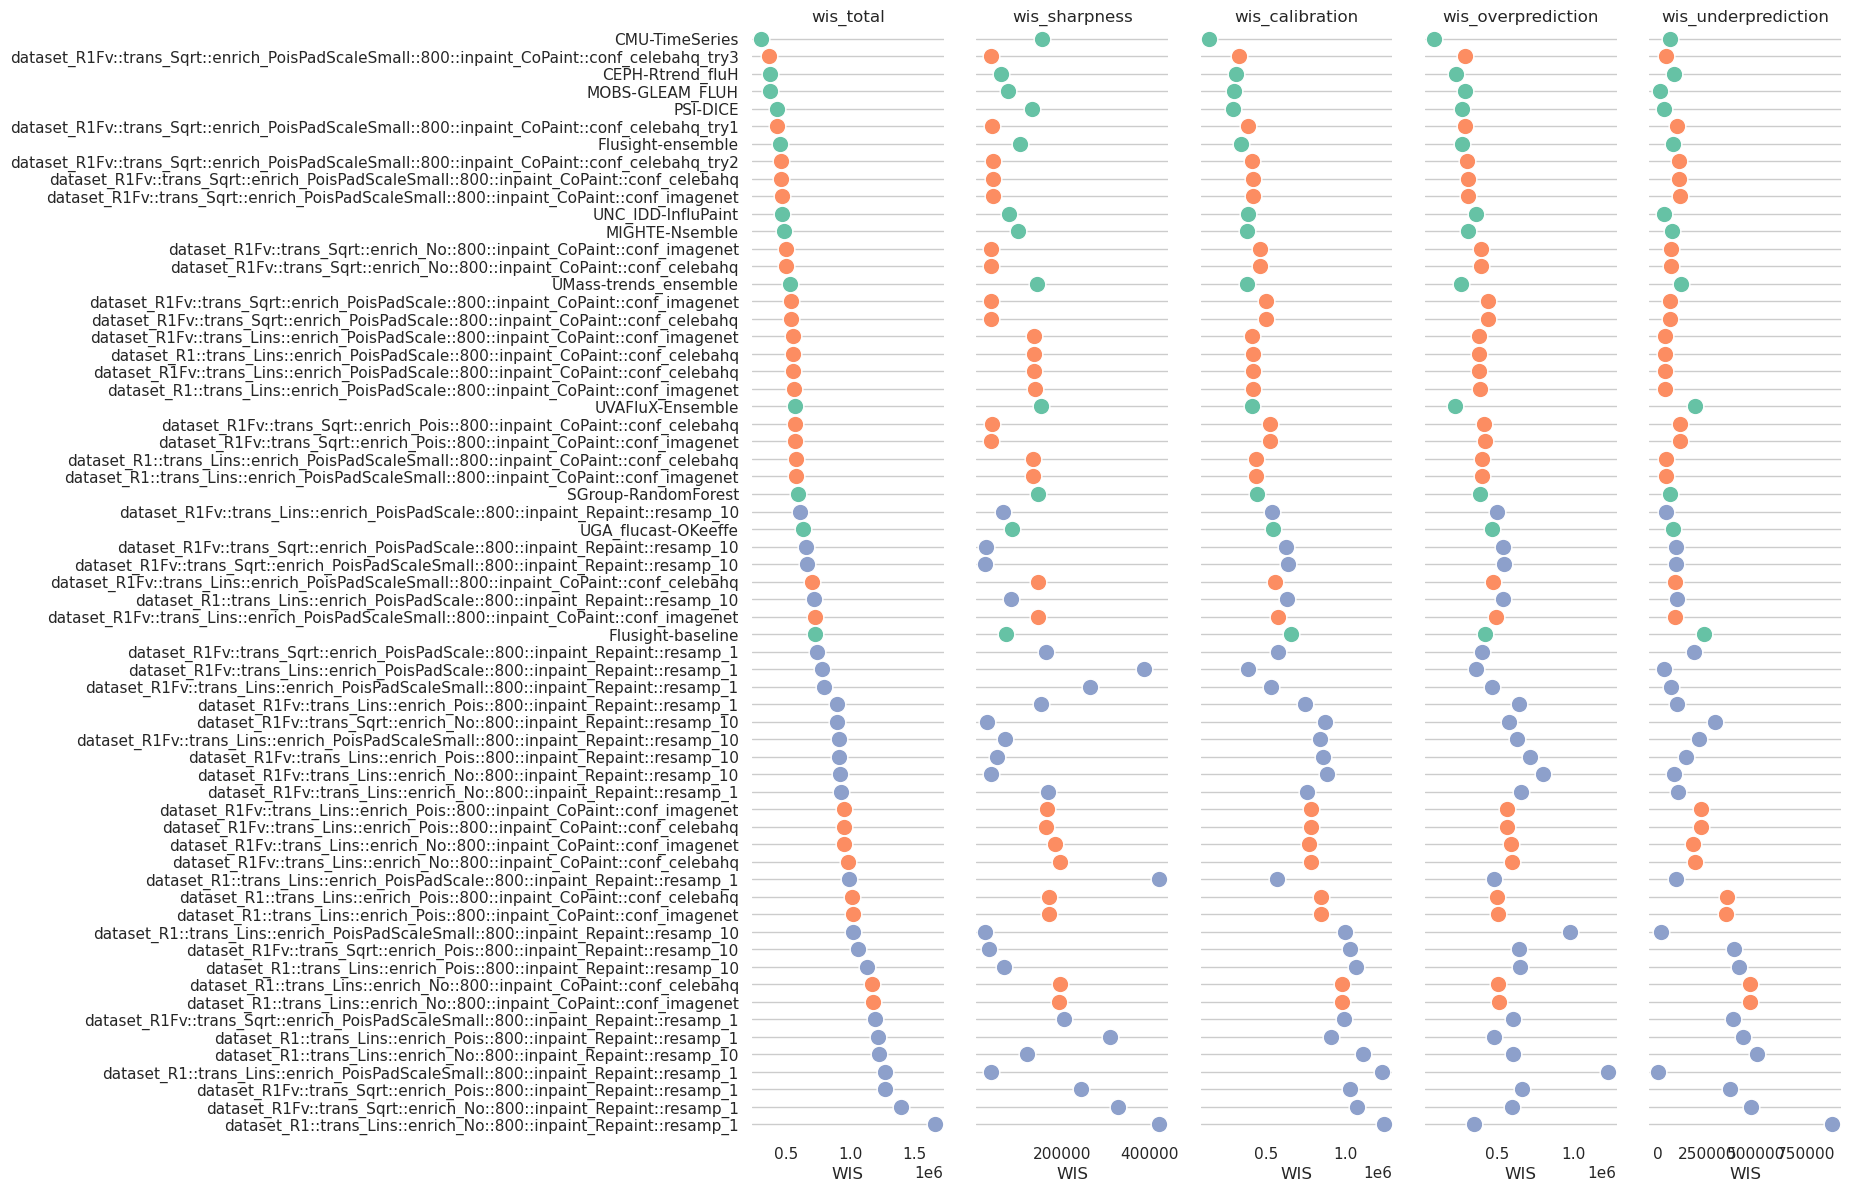

In [33]:
sns.set_theme(style="whitegrid")

to_plot = all_loc_df
#to_plot = us_df
to_plot['color'] = 0.0  # Default color

# Set the color to 'red' for models with '::' in their names
to_plot.loc[to_plot['model'].str.contains('::'), 'color'] = 3
to_plot.loc[to_plot['model'].str.contains('CoPaint'), 'color'] = 2

to_plot = to_plot.sort_values("wis_total").reset_index()

if False:
    to_plot = to_plot.iloc[:int(to_plot[to_plot["model"]=="JHU_IDD-CovidSP"].index[0])+1]


# Make the PairGrid
g = sns.PairGrid(to_plot.sort_values("wis_total"),
                    x_vars=[ 'wis_total', 'wis_sharpness', 'wis_calibration',  'wis_overprediction', 'wis_underprediction'], y_vars=["model"], # to_plot.columns[-5:]
                    hue='color',palette="Set2", 
                    height=12, aspect=.2)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=12, orient="h", jitter=False, #color=to_plot['color'],
    
    linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="WIS", ylabel="")#xlim=(to_plot[to_plot.columns[-5:]].max().max()), 

# Use semantically meaningful titles for the columns
titles = [ 'wis_total', 'wis_sharpness', 'wis_calibration',  'wis_overprediction', 'wis_underprediction']

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [20]:
to_plot

wis_type,model,wis_calibration,wis_overprediction,wis_sharpness,wis_total,wis_underprediction,color
0,CEID-Walk,4257.071772,1931.653392,9663.979050,1.392105e+04,2325.418381,0.0
1,CEPH-Rtrend_fluH,311184.072450,229011.142951,62007.884613,3.731920e+05,82172.929499,0.0
2,CMU-TimeSeries,147664.073732,84624.212470,154705.306409,3.023694e+05,63039.861261,0.0
3,CU-ensemble,475252.704595,301536.118162,46982.459934,5.222352e+05,173716.586433,0.0
4,Flusight-baseline,655318.161926,422897.155361,71656.223195,7.269744e+05,232421.006565,0.0
...,...,...,...,...,...,...,...
68,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScale:...,626246.047070,537073.760563,26531.243311,6.527773e+05,89172.286508,3.0
69,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,418585.817615,309371.177685,42842.117634,4.614279e+05,109214.639930,2.0
70,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,420898.321574,310556.798942,43435.672871,4.643340e+05,110341.522632,2.0
71,dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleS...,985567.558172,602137.739991,204842.058039,1.190410e+06,383429.818180,3.0


In [15]:
a = wis_total[["wis_total","model"]].groupby("model").sum().sort_values(by="wis_total")
a

,wis_total
model,
CEID-Walk,1.392105e+04
UGuelph-FluPLUG,1.188566e+05
UMass-gbq,1.347362e+05
CMU-TimeSeries,3.023694e+05
CEPH-Rtrend_fluH,3.731920e+05
...,...
test::model_MyUnet200::dataset_R1::trans_Lins::enrich_No::800::inpaint_Repaint::resamp_10,1.225091e+06
test::model_MyUnet200::dataset_R1::trans_Lins::enrich_PoisPadScaleSmall::800::inpaint_Repaint::resamp_1,1.265712e+06
test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_Pois::800::inpaint_Repaint::resamp_1,1.267627e+06


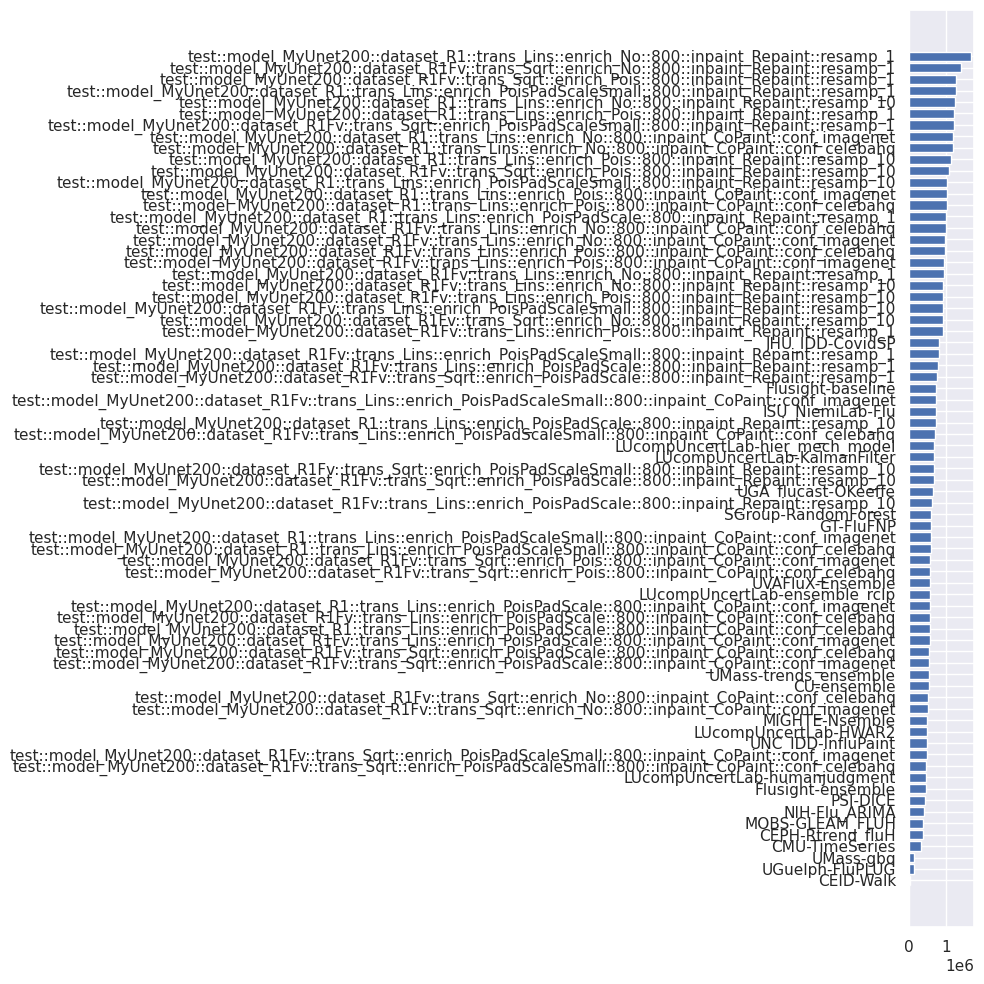

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.barh(a.index, a["wis_total"])


plt.tight_layout()
plt.show()


In [23]:
a = wis_total[["wis_total","model"]].groupby("model").sum().sort_values(by="wis_total")
a

,wis_total
model,
NIH-Flu_ARIMA,5.347349e+05
CU-ensemble,5.854500e+05
MOBS-GLEAM_FLUH,6.573592e+05
CMU-TimeSeries,6.624845e+05
SGroup-RandomForest,6.850440e+05
GT-FluFNP,7.831573e+05
PSI-DICE,7.847929e+05
UGA_flucast-OKeeffe,7.948820e+05
LUcompUncertLab-humanjudgment,8.451724e+05


In [ ]:
all_scores

In [ ]:
tp = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [ ]:
tp = wis_total[wis_total["target"]=="1 wk ahead"].pivot(values="wis_total", index="location", columns="forecast_date")
tp = np.log(tp)
f, ax = plt.subplots(figsize=(9, 12))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [ ]:
# tp = wis_total.pivot(values="wis_total", index="location", columns=["forecast_date","target"])
# tp = np.log(tp)
# f, ax = plt.subplots(figsize=(12, 12), dpi=300)
# sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [ ]:
tp1 = wis_underprediction[wis_underprediction["location"]=="US"].pivot(values="wis_underprediction", index="target", columns="forecast_date")
tp2 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp1 = wis_sharpness[wis_sharpness["location"]=="US"].pivot(values="wis_sharpness", index="target", columns="forecast_date")
tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())

In [ ]:
tp1 = wis_underprediction[wis_underprediction["location"]=="US"].pivot(values="wis_underprediction", index="target", columns="forecast_date")
#tp2 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())

In [ ]:
tp1 = wis_overprediction[wis_overprediction["location"]=="US"].pivot(values="wis_overprediction", index="target", columns="forecast_date")

tp2 = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(tp1/tp2, annot=False, fmt="", linewidths=1, ax=ax)
print((tp1/tp2).mean().mean())